# Thalamocortical loops for fast initial state prepration

## Notebook setup

### Magics

In [1]:
%reset -f
%load_ext autoreload
%autoreload 2
%matplotlib inline

### Imports

In [2]:
import numpy as np
import numpy.random as npr
np.set_printoptions(linewidth=200)

from matplotlib import pyplot as plt
import seaborn as sns
plt.rcParams['figure.dpi'] = 150

from time import time
import inspect

import tensorflow as tf
import tensorflow_probability as tfp

### Version check
We want Tensorflow 2.3 and Tensorflow Probability 0.11

In [3]:
print(f'tf version: {tf.__version__}')
print(f'tfp version: {tfp.__version__}')
print(f'GPUs: {[device.name for device in tf.config.list_physical_devices("GPU")] if len(tf.config.list_physical_devices("GPU")) else None}')

tf version: 2.3.0
tfp version: 0.11.0
GPUs: None


### We will need a custom eigendecompostion operation
Tensorflow's internal `eig` function is single-threaded and __very__ slow. Here we wrap numpy's fast algorithm as a Tensorflow op. We have to provide a custom gradient which has been described in equation 4.77 in [Boeddeker et at. 2017](https://arxiv.org/pdf/1701.00392.pdf "arXiv:1701.00392"). If for matrix $A$, $\Lambda$ is the diagonal matrix of its eigenvalues and $V$ the matrix of its right eigenvectors, then the gradient is given as
$$
\nabla_{A^*}=V^{-\mathsf H}\left[\nabla_{\Lambda^*}+F^*\circ\left(V^\mathsf H\nabla_{V^*} - V^\mathsf HV(V^\mathsf H\nabla_{V^*}\circ I)\right)\right]V^\mathsf H,
$$
where $F_{ii}=0$ and $\forall_{i\ne j}, F_{ij}=(\lambda_j-\lambda_i)^{-1}$, and $\nabla_{\Lambda^*}$ and $\nabla_{V^*}$ are the gradients w.r.t. the conjugates of $\Lambda$ and $V$ (which are backpropogated by Tensorflow).

Note that we have omitted a cast-to-real step in equation 4.77. [@refraction-ray](https://github.com/refraction-ray "@refraction-ray on GitHub") has shown on [their blog](https://re-ra.xyz/Gauge-Problem-in-Automatic-Differentiation "Gauge Problem in Automatic Differentiation") that this step is unnecessary (see equation 19).

In [4]:
# a stable version of 1/x
def _reciprocal(x, ep=1e-20):
    return x / (x * x + ep)

# wrapper of numpy's eig() with custom gradient
@tf.custom_gradient
def _myeig(A):
    e, v = np.linalg.eig(A)
    def grad(grad_e, grad_v):
        f = _reciprocal(e[..., None, :] - e[..., None])
        f = tf.linalg.set_diag(f, tf.zeros_like(e))
        f = tf.math.conj(f)
        vt = tf.linalg.adjoint(v)
        vgv = vt @ grad_v
        mid = tf.linalg.diag(grad_e) + f * (vgv - vt @ (v * tf.linalg.diag_part(vgv)[..., None, :]))
        grad_a = tf.linalg.solve(vt, mid @ vt)
        return tf.cast(grad_a, A.dtype)
    return (e, v), grad

# wrapper of Tensorflow's py_function(), which let's us use our custom op
def myeig(A):
    if A.dtype == tf.float32:
        return tf.py_function(func=_myeig, inp=[A], Tout=[tf.complex64, tf.complex64])
    elif A.dtype == tf.float64:
        return tf.py_function(func=_myeig, inp=[A], Tout=[tf.complex128, tf.complex128])
    else:
        raise NotImplementedError('Expecting tf.float32 or tf.float64')

## Problem setup
Consider a simple linear dynamical system:
$$
\tau\dot x = -x + Jx,
$$
or:
$$
\begin{align}
x(t)&=e^{(J-I)\frac{t}{\tau}}x_0\\
&=Re^{(\Lambda-I)\frac{t}{\tau}}Lx_0\\
&=Re^{\Gamma t}Lx_0,
\end{align}
$$
where $x_0$ is the length-$N$ initial condition vector, $R$ and $L$ are the matrices of right and left eigenvectors of the $N\times N$ weight matrix $J$, $\Lambda$ is the diagonal matrix of the eigenvalues of $J$, $I$ is the identify matrix, and $\Gamma=(\Lambda-I)/\tau$.

We define $J$ as:
$$
J=J_0+UV
$$
with $N\times n$ and $n\times N$ matrices $U$ and $V$ (for $n<N$), and $\left<\left[J_0\right]_{ij}\right>=0$ and $\left<\left[J_0\right]_{ij}^2\right>=1/N$. This means that the eigenspectrum of $J_0$ is uniformly distributed on the unit disc.

### Model parameters
As we learn $U$ and $V$ (see below), we can apply a constraint such that either the columns of $U$ and the rows of $V$ have unit norms (more restrictive) or the elements of the product $UV$ have variance $1/N$ (less restrictive). Or we can leave the weights of $U$ and $V$ unconstrainted. We select these options by setting `normalization_scheme` to `'raw_weights'`, `'perturbation_weights'`, or `'none'`.

In [5]:
# simulation parameters
dt = 0.001  # time step (s)
n_seconds = 0.1  # simultation time at test (s)

# network parameters
tau = 0.01  # neural time constant (s)
N = 500  # network size
n_frac = 0.1  # rank of U and V as fraction of N
normalization_scheme = 'raw_weights'  # normalization for U and V ('raw_weights', 'perturbation_weights', or None)

# random seeds
numpy_seed = 2

### Build model

In [6]:
# set numpy seed
npr.seed(numpy_seed)

# sample J0
J0 = npr.randn(N, N) / np.sqrt(N)

# sample U and V
n = int(round(N * n_frac))  # n from n_frac
sigma_U = sigma_V = 1 / np.sqrt(N)  # default scaling for 'raw weights' option
if normalization_scheme == 'perturbation_weights':
    sigma_U = 1 / (n * N)**0.25
    sigma_V = 1 / (n * N)**0.25
V = npr.randn(n, N) * sigma_V
U = npr.randn(N, n) * sigma_U

# sample w
w = npr.randn(N) / np.sqrt(N)

### Initial eigenvalues of $J_0$ and $J_0+UV$
Let's plot the eigenvalues of $J_0$ and $J_0 + UV$ in the complex plane

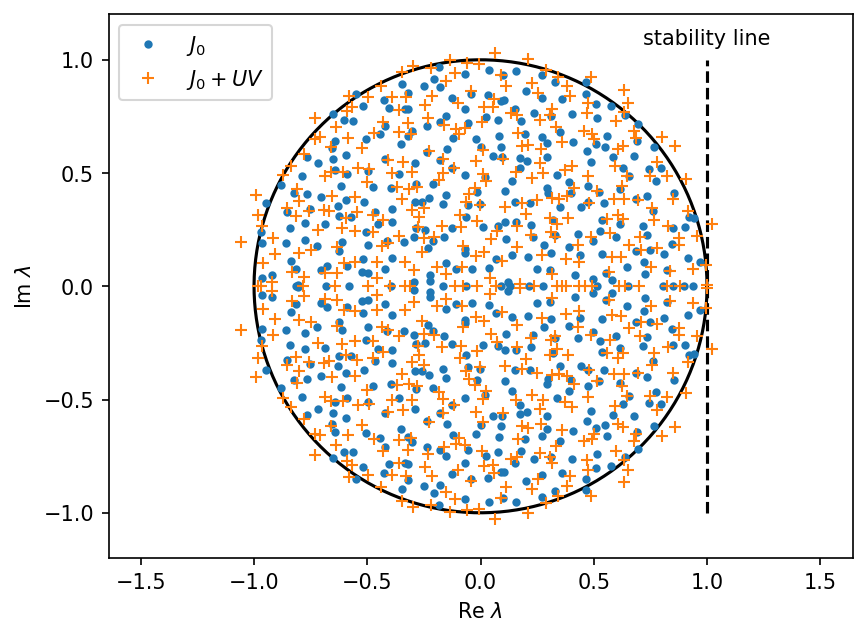

In [7]:
fig, ax = plt.subplots(1, 1, figsize=[6.4, 4.8])
theta = np.linspace(0, 2 * np.pi, 500)
d, v = np.linalg.eig(J0)
d0, v0 = np.linalg.eig(J0 + U @ V)
plt.plot(np.cos(theta), np.sin(theta), 'k')
plt.plot([1, 1], [-1, 1], '--k')
plt.plot(d.real, d.imag, '.')
plt.plot(d0.real, d0.imag, '+')
plt.xlabel('Re $\lambda$')
plt.ylabel('Im $\lambda$')
plt.text(1, 1.05, 'stability line', ha='center', va='bottom')
plt.axis('equal')
ax.set(xlim=(-1.2, 1.2), ylim=(-1.2, 1.2))
plt.legend(plt.gca().get_children()[2:], ['$J_0$', '$J_0 + UV$']);

## Loss function
Our goal is to find low rank matrices $U$ and $V$ such that $x$ decays to zero as quickly as possible independent of $x_0$. Thus, the first part of our loss function is the integral under the squared norm of $x$ averaged over $x_0$ and normalized by $N$ and $\tau$:
$$
\begin{align}
L_1(U,V)&=\frac{1}{N\tau}\mathbb E_{x_0}\left\{
\int_0^\infty dt\ \|x(t)\|^2
\right\}\\
&=\frac{1}{N\tau}\mathbb E_{x_0}\left\{
\int_0^\infty dt\ x_0^\mathsf TL^\mathsf He^{\Gamma^\mathsf Ht}R^\mathsf HRe^{\Gamma t}Lx_0
\right\}\\
&=\frac{1}{N\tau}\mathbb E_{x_0}\left\{
\int_0^\infty dt\ \textsf{Tr}\left(Re^{\Gamma t}Lx_0x_0^\mathsf TL^\mathsf He^{\Gamma^\mathsf Ht}R^\mathsf H
\right)
\right\}\\
&=\frac{1}{N\tau}\textsf{Tr}\left(\int_0^\infty dt\ Re^{\Gamma t}L\mathbb E_{x_0}\left\{x_0x_0^\mathsf T\right\}L^\mathsf He^{\Gamma^\mathsf Ht}R^\mathsf H
\right)\\
&=\frac{1}{N\tau}\textsf{Tr}\left(\int_0^\infty dt\ Re^{\Gamma t}LL^\mathsf He^{\Gamma^\mathsf Ht}R^\mathsf H
\right)\\
&=\frac{1}{N\tau}\textsf{Tr}\left(R\left(LL^\mathsf H\circ F\right)R^\mathsf H\right),
\end{align}
$$
where we assume $x_0$ is centered with covariance $I$ and we define $F$ such that $F_{ij}=-1/(\gamma_i + \gamma_j^*)$ with $\gamma_i$ as the $i^\textsf{th}$ diagonal element of $\Gamma$.

This loss is only sensical if $\forall_i,\textsf{Re}(\lambda_i)<1$ (see dotted line above). Thus we add a penalty to enforce this:
$$
\begin{align}
L_2(U,V)&=\sum_i\max(\textrm{Re}(\gamma_i),0)^2.
\end{align}
$$

Finally, the output of our system is given as $y=w^\mathsf Tx$ and, during the decay of $x$, we desired this output to be smooth. Thus we add to following term to our loss:
$$
\begin{align}
L_3(U,V) &=\frac{1}{\tau}\mathbb E_{x_0}\left\{\int_0^\infty dt\ \left(\tau\frac{d}{dt}w^\mathsf Tx\right)^2\right\}\\
&=\tau\,\mathbb E_{x_0}\left\{\int_0^\infty dt\ \left(w^\mathsf TRe^{\Gamma t}\Gamma Lx_0\right)^2\right\}\\
%&=\mathbb E_{x_0}\left\{\int_0^\infty dt\ w^\mathsf TRe^{\Gamma t}\Gamma Lx_0x_0^\mathsf TL^\mathsf H\Gamma^\mathsf He^{\Gamma^\mathsf H t}R^\mathsf Hw\right\}\\
&=\tau\int_0^\infty dt\ w^\mathsf TRe^{\Gamma t}\Gamma LL^\mathsf H\Gamma^\mathsf He^{\Gamma^\mathsf H t}R^\mathsf Hw\\
&=\tau\,w^\mathsf TR(LL^\mathsf H\circ G)R^\mathsf Hw,
\end{align}
$$
where we define $G$ such that $G_{ij}=\gamma_i\gamma_j^*F_{ij}$.

Our total loss is thus:
$$
\mathcal L(U,V) = L_1(U,V) + \alpha L_2(U,V) + \beta L_3(U,V),
$$
where $\alpha$ and $\beta$ are hyperparameters weighting the importance of $L_2$ and $L_3$ relative to $L_1$.

### Loss parameters

In [8]:
# penalty for solutions that don't decay
alpha = 1e5

# smoothness constraint
betas = [0.0, 0.01, 0.1]
beta = betas[1]  # The value used for all figures except the beta comparison figure

### Loss function code

In [9]:
# param is a 1-d tensor; reshape to 2 x N x n tensor, then extract U & V.T; renormalize U & V.T if needed; return U and V
def _extract_U_and_V(param):
    param = tf.reshape(param, (2, N, -1))
    U, V = param[0], param[1]
    if normalization_scheme == 'raw_weights' or normalization_scheme == 'perturbation_weights':
        U = (U / tf.linalg.norm(U, axis=-2, keepdims=True)) * np.sqrt(N) * sigma_U
        V = (V / tf.linalg.norm(V, axis=-2, keepdims=True)) * np.sqrt(N) * sigma_V
    else:
        U = U / tf.linalg.norm(U, axis=-2, keepdims=True)  # we always normalize U since there is a scale factor degree of freedom in the product UV
    return U, tf.linalg.matrix_transpose(V)

# get J0 + UV from param and J0
def _extract_J(param, J0):
    U, V = _extract_U_and_V(param)
    return J0 + U @ V

# get loss from eigenvalues d and eigenvectors r and other parameters
def _loss_from_eigs(d, r, w, tau, alpha, beta):
    L = tf.linalg.inv(tf.linalg.adjoint(r) @ r)
    g = (d - 1) / tau
    g_real = tf.math.real(g)
    F = -_reciprocal(g[:, None] + tf.math.conj(g))
    G = (g[:, None] * tf.math.conj(g)) * F
    wR = tf.linalg.matvec(r, tf.cast(w, tf.complex128), transpose_a=True)
    return tf.math.real(tf.reduce_sum((r @ (L * F)) * tf.math.conj(r)) / N / tau + beta * tau * tf.reduce_sum(wR * tf.linalg.matvec(L * G, tf.math.conj(wR)))) \
           + alpha * tf.reduce_sum(tf.where(g_real < 0, tf.zeros_like(g_real), g_real)**2)

# return the loss and gradient
def loss_and_grad(param, J0, w, tau, alpha, beta, gradient=False):
    with tf.GradientTape() as tape:
        tape.watch(param)
        J = _extract_J(param, J0)
        d, r = myeig(J)
        loss = _loss_from_eigs(d, r, w, tau, alpha, beta)
    return loss, tape.gradient(loss, param)

## Learning
There are no batches here and the number of parameters is relatively small, so quasi-Newton optimization should be fast. However, empirically, we've found that L-BFGS is unstable at the beginning of optimization when starting from random $U$ and $V$. Thus we start with a few steps of ADAM followed by L-BFGS. 

### Learning parameters
We will also save the loss in `losses` for later plotting

In [10]:
# learning
adam_epochs = 30
adam_learning_rate = 0.01
lbfgs_iters = 200
print_interval = 15

# for learning curve
losses = []

# initial parameters
init_param = tf.constant(np.stack((U, V.T)).flatten())

### ADAM optimization

In [11]:
if adam_epochs > 0:
    params = []
    for beta in betas:
        _losses = []
        param = tf.Variable(init_param)
        opt = tf.keras.optimizers.Adam(learning_rate=adam_learning_rate)
        print(f'Starting ADAM optimization; beta = {beta:.2f}')
        cur = _cur = time()
        # initial loss value
        loss, grad = loss_and_grad(param, J0, w, tau, alpha, beta)
        _losses.append(loss.numpy())

        # perform `adam_epochs` cycles of ADAM
        for i in range(adam_epochs):
            if i % print_interval == 0:
                print(f"   epoch: {i:3d}, time: {time() - _cur:6.2f} s, loss: {_losses[-1]:8f}")
                _cur = time()
            opt.apply_gradients(zip([grad], [param]))
            loss, grad = loss_and_grad(param, J0, w, tau, alpha, beta)
            _losses.append(loss.numpy())
        print(f"   epoch: {adam_epochs:3d}, time: {time() - _cur:6.2f} s, loss: {_losses[-1]:8f}")
        print(f'ADAM completed')
        print(f'   total time: {time() - cur:.2f} s')
        print(f'   num epochs: {adam_epochs:d}')
        print(f'   loss: {_losses[-1]:.8f}')
        _losses = _losses[:-1]
        losses.append(_losses)
        param = tf.constant(param.numpy())
        params.append(param)
else:
    losses = [[] for beta in betas]
    params = [init_param] * len(betas)
    print('skipping initial ADAM steps')

Starting ADAM optimization; beta = 0.00
   epoch:   0, time:   0.50 s, loss: 847949.957052
   epoch:  15, time:   7.18 s, loss: 2.011176
   epoch:  30, time:   8.58 s, loss: 1.912037
ADAM completed
   total time: 16.25 s
   num epochs: 30
   loss: 1.91203651
Starting ADAM optimization; beta = 0.01
   epoch:   0, time:   0.51 s, loss: 847949.969712
   epoch:  15, time:   8.26 s, loss: 2.021427
   epoch:  30, time:   8.07 s, loss: 1.922324
ADAM completed
   total time: 16.85 s
   num epochs: 30
   loss: 1.92232364
Starting ADAM optimization; beta = 0.10
   epoch:   0, time:   0.54 s, loss: 847950.083647
   epoch:  15, time:   8.01 s, loss: 2.113693
   epoch:  30, time:   8.05 s, loss: 2.014908
ADAM completed
   total time: 16.60 s
   num epochs: 30
   loss: 2.01490781


### L-BFGS optimization

In [12]:
for b, (beta, param, _losses) in enumerate(zip(betas, params, losses)):
    print(f'Starting L-BFGS optimization')
    cur  = _cur = time()
    # initialize results object
    results = tfp.optimizer.lbfgs_minimize(
        lambda x: loss_and_grad(x, J0, w, tau, alpha, beta),
        initial_position=param,
        max_iterations=0,
        tolerance=1e-5,
        x_tolerance=1e-5,
        f_relative_tolerance=1e-5
    )
    _losses.append(results.objective_value.numpy())

    # run one step of L-BFGS at a time
    for i in range(lbfgs_iters):
        if i % print_interval == 0:
            print(f"   iter: {i:3d}, fn_evals: {results.num_objective_evaluations:4d}, time: {time() - _cur:6.2f} s, loss: {_losses[-1]:8f}")
            _cur = time()
        results = tfp.optimizer.lbfgs_minimize(
            lambda x: loss_and_grad(x, J0, w, tau, alpha, beta),
            initial_position=None,
            previous_optimizer_results=results,
            max_iterations=results.num_iterations + 1,
            tolerance=1e-5,
            x_tolerance=1e-5,
            f_relative_tolerance=1e-5
        )
        _losses.append(results.objective_value.numpy())
        if np.all(results.converged | results.failed):
            break
    print(f"   iter: {results.num_iterations:3d}, fn_evals: {results.num_objective_evaluations:4d}, time: {time() - _cur:6.2f} s, loss: {_losses[-1]:8f}")
    print(f'L-BFGS completed')
    print(f'   total time: {time() - cur:.2f} s')
    print(f'   num iters: {results.num_iterations:d}')
    print(f'   num func evals: {results.num_objective_evaluations:d}')
    print(f'   frac converged: {results.converged.numpy().mean():.3f}')
    print(f'   frac failed: {results.failed.numpy().mean():.3f}')
    print(f'   loss: {results.objective_value.numpy():.8f}')
    losses[b] = _losses
    params[b] = results.position

Starting L-BFGS optimization
   iter:   0, fn_evals:    1, time:   0.57 s, loss: 1.912037
   iter:  15, fn_evals:   47, time:  27.87 s, loss: 0.634853
   iter:  19, fn_evals:   59, time:   8.35 s, loss: 0.633685
L-BFGS completed
   total time: 36.79 s
   num iters: 19
   num func evals: 59
   frac converged: 1.000
   frac failed: 0.000
   loss: 0.63368476
Starting L-BFGS optimization
   iter:   0, fn_evals:    1, time:   0.61 s, loss: 1.922324
   iter:  15, fn_evals:   47, time:  28.09 s, loss: 0.642107
   iter:  20, fn_evals:   62, time:   9.02 s, loss: 0.640463
L-BFGS completed
   total time: 37.72 s
   num iters: 20
   num func evals: 62
   frac converged: 1.000
   frac failed: 0.000
   loss: 0.64046323
Starting L-BFGS optimization
   iter:   0, fn_evals:    1, time:   0.55 s, loss: 2.014908
   iter:  15, fn_evals:   42, time:  26.57 s, loss: 0.699649
   iter:  30, fn_evals:   87, time:  26.58 s, loss: 0.656444
   iter:  45, fn_evals:  131, time:  28.40 s, loss: 0.652812
   iter:  6

## Display results
Here, we will plot:
* the learning curve
* sample network activity norms before and after optimization, and will note the theoretical decay times
* the eigenvalues of $J_0$ and $J_0+UV$ before and after optimization
* the distribtions of the weights of $J_0$, $U$, $V$, and $UV$.

### Parameters & data collection

In [13]:
# the number of samples to simulate and plot
test_runs = 5
x_init = npr.randn(N, test_runs)
t = np.arange(n_seconds / dt) * dt

# get random trajectories from J0 + UV before optimization
tmp = v0 @ (np.exp((d0[:, None] - 1) * t / tau) * np.linalg.solve(v0, x_init).T[..., None])
assert np.allclose(tmp.imag, 0)
norms0_ = np.linalg.norm(tmp, axis=-2)

# get random outputs for each beta
outputs = []
for param in params:
    U_end, V_end = _extract_U_and_V(param)
    d_end, v_end = np.linalg.eig(J0 + U_end @ V_end)
    tmp = v_end @ (np.exp((d_end[:, None] - 1) * t / tau) * np.linalg.solve(v_end, x_init).T[..., None])
    assert np.allclose(tmp.imag, 0)
    outputs.append(w @ tmp.real)
outputs = np.stack(outputs)
    
# get random trajectories from J0 + UV after optimization at preferred beta
idx = (np.array(betas) == beta).nonzero()[0][0]
U_end, V_end = _extract_U_and_V(params[idx])
d_end, v_end = np.linalg.eig(J0 + U_end @ V_end)
tmp = v_end @ (np.exp((d_end[:, None] - 1) * t / tau) * np.linalg.solve(v_end, x_init).T[..., None])
assert np.allclose(tmp.imag, 0)
norms_ = np.linalg.norm(tmp, axis=-2)

We can calculate the time $t_d$ to decay to some fraction $f$ of the initial norm of the activity using this approximation:
$$
f=\mathbb E_{x_0}\left\{\frac{\|x(t_d)\|}{\|x_0\|}\right\}\approx\sqrt{\mathbb E_{x_0}\left\{\frac{\|x(t_d)\|^2}{N}\right\}}.
$$
This yields the following indirect function for $t_d$ that we can solve numerically:
$$
\begin{align}
f^2&=\frac{1}{N}\mathbb E_{x_0}\left\{\|x(t)\|^2\right\}\\
&=\frac{1}{N}\mathbb E_{x_0}\left\{
\textsf{Tr}\left(Re^{\Gamma t}Lx_0x_0^\mathsf TL^\mathsf He^{\Gamma^\mathsf Ht}R^\mathsf H\right)\right\}\\
&=\frac{1}{N}\textsf{Tr}\left(R\left(LL^\mathsf H\circ E(t)\right)R^\mathsf H\right),
\end{align}
$$
where $E_{ij}(t)=e^{(\gamma_i + \gamma_j^*)t}$.

In [14]:
f = [0.01, 0.05]  # calculate for 1% and 5%
L = tf.linalg.inv(tf.linalg.adjoint(v_end) @ v_end)
g = (d_end - 1) / tau

def norm_frac_remaining(t):
    E = tf.math.exp((g[:, None] + tf.math.conj(g)) * tf.cast(t, tf.complex128)[:, None, None])
    return tf.math.sqrt(tf.math.real(tf.reduce_sum((v_end @ (L * E)) * tf.math.conj(v_end), axis=[-1, -2])) / N)

start = np.ones(len(f), dtype='float64') * 10 * tau
f = tf.constant(f, dtype=tf.float64)
optim_results = tfp.optimizer.bfgs_minimize(
    lambda x: tfp.math.value_and_gradient(
        lambda x: tf.reduce_sum(
            (norm_frac_remaining(x) - f)**2, axis=-1), 
        x),
    initial_position=start,
    tolerance=1e-8)
t_d = optim_results.position
print(f'decay times {t_d.numpy()} seconds for norm fractions {norm_frac_remaining(t_d).numpy()}')

decay times [0.10886055 0.05267489] seconds for norm fractions [0.01 0.05]


### Plot results

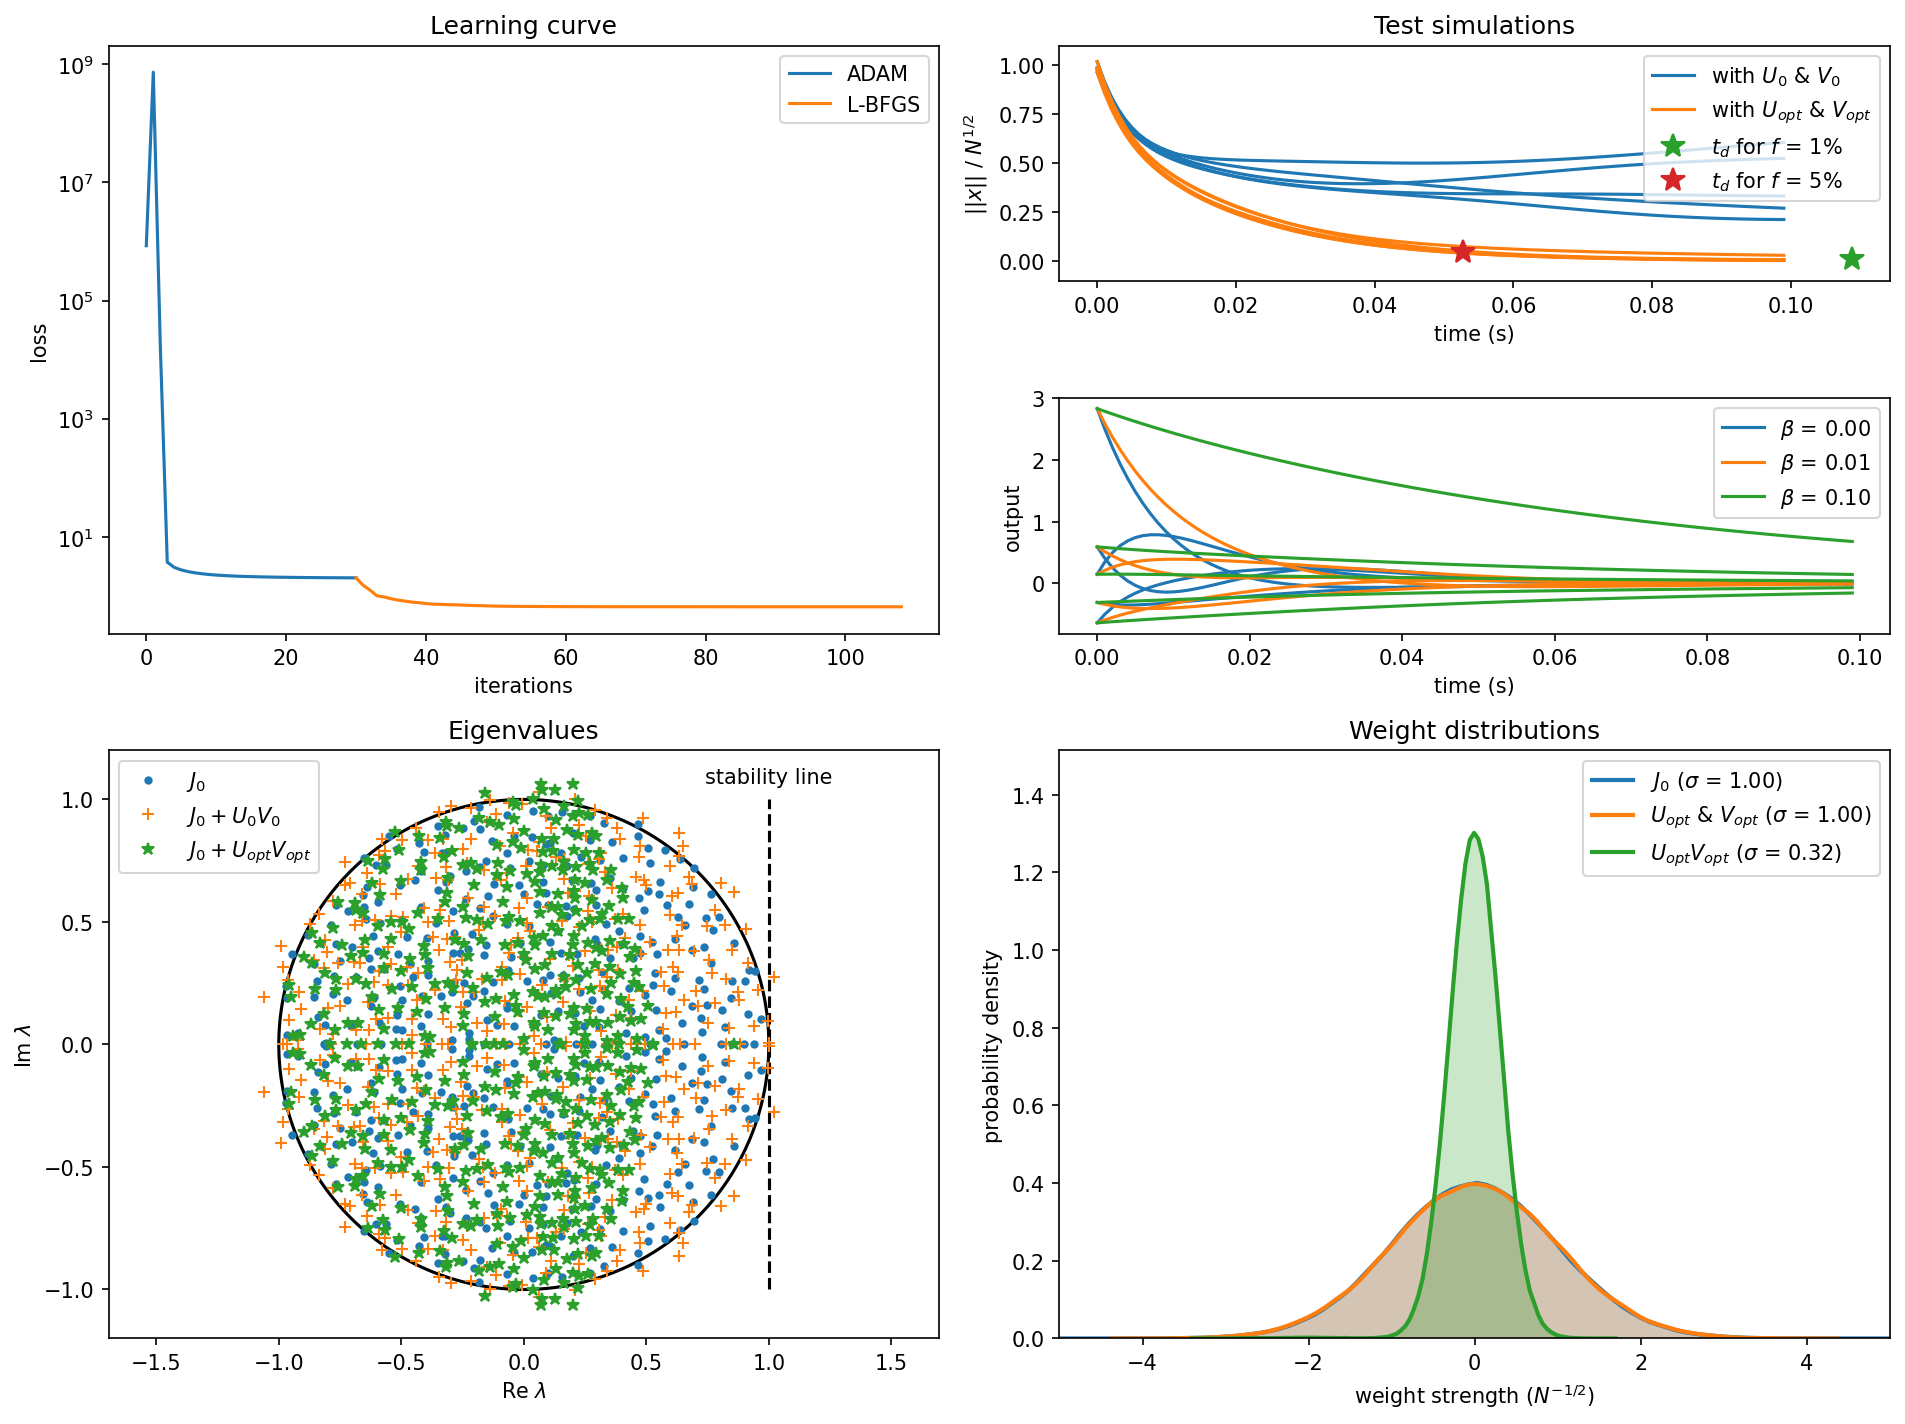

In [15]:
fig, axes = plt.subplots(4, 2, figsize=[6.4 * 2, 4.8 * 2])

colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']

gs = axes[0, 0].get_gridspec()
for a, ax in enumerate(axes):
    ax[0].remove()
    if a > 1:
        ax[1].remove()
a1 = fig.add_subplot(gs[:2, 0])
a2 = fig.add_subplot(gs[2:, 0])
a3 = fig.add_subplot(gs[2:, 1])

# Learning curve
a1.plot(losses[idx][:adam_epochs + 1])
a1.plot(np.arange(adam_epochs, len(losses[idx])), losses[idx][adam_epochs:])
a1.set_yscale('log')
# a1.set_ylim(0, 10)
a1.set_xlabel('iterations')
a1.set_ylabel('loss')
a1.legend(['ADAM','L-BFGS'])
a1.set_title('Learning curve')

# Norms of sample trajectories
axes[0, 1].plot(t, norms0_.T / N**0.5, color='tab:blue')
axes[0, 1].plot(t, norms_.T / N**0.5, color='tab:orange')
for _f, _t_d, c in zip(f, t_d.numpy(), ['tab:green', 'tab:red']): axes[0, 1].plot(_t_d, _f, '.', color=c, marker='*', markersize=12)
axes[0, 1].set_ylim(-0.1, 1.1)
axes[0, 1].set_xlabel('time (s)')
axes[0, 1].set_ylabel('$||x||$ / $N^{1/2}$')
axes[0, 1].legend([axes[0, 1].get_children()[0], axes[0, 1].get_children()[test_runs], *axes[0, 1].get_children()[2 * test_runs:2 * test_runs + 2]], ['with $U_0$ & $V_0$','with $U_{opt}$ & $V_{opt}$', f'$t_d$ for $f$ = {f[0] * 100:.0f}%', f'$t_d$ for $f$ = {f[1] * 100:.0f}%'])
axes[0, 1].set_title('Test simulations')

# Norms of sample trajectories
# axes[0, 1].plot(t, norms0_.T / N**0.5, color='tab:blue')
for b, output in enumerate(outputs): axes[1, 1].plot(t, output.T, color=colors[b])
# for _f, _t_d, c in zip(f, t_d.numpy(), ['tab:green', 'tab:red']): axes[0, 1].plot(_t_d, _f, '.', color=c, marker='*', markersize=12)
# axes[0, 1].set_ylim(-0.1, 1.1)
axes[1, 1].set_xlabel('time (s)')
axes[1, 1].set_ylabel('output')
kids = axes[1, 1].get_children() 
axes[1, 1].legend(kids[:test_runs * len(betas):test_runs], [f'$\\beta$ = {beta:.2f}' for beta in betas])
# axes[0, 1].set_title('Test simulations')

# Eigenvalues
a2.plot(np.cos(theta), np.sin(theta), 'k')
a2.plot([1, 1], [-1, 1], '--k')
h1 = a2.plot(d.real, d.imag, '.')[0]
h2 = a2.plot(d0.real, d0.imag, '+', fillstyle='none')[0]
h3 = a2.plot(d_end.real, d_end.imag, '*')[0]
a2.legend([h1, h2, h3], ['$J_0$', '$J_0 + U_0V_0$', '$J_0 + U_{opt}V_{opt}$'], loc='upper left')
a2.set_xlabel('Re $\lambda$')
a2.set_ylabel('Im $\lambda$')
a2.text(1, 1.05, 'stability line', ha='center', va='bottom')
a2.axis('equal')
a2.set(xlim=(-1.2, 1.2), ylim=(-1.2, 1.2))
a2.set_title('Eigenvalues')


# Weight distributions
sns.distplot(J0.flatten() * N**0.5, hist = False, kde = True,
                 kde_kws = {'linewidth': 2, 'shade': True},
                 label = f'$J_0$ ($\sigma$ = {J0.flatten().std() * N**0.5:4.2f})', ax=a3)
sns.distplot(np.concatenate((U_end, tf.transpose(V_end)), -1).flatten() * N**0.5, hist = False, kde = True,
                 kde_kws = {'linewidth': 2, 'shade': True},
                 label = r'$U_{opt}$ & $V_{opt}$' + f' ($\sigma$ = {np.concatenate((U_end, tf.transpose(V_end)), -1).flatten().std() * N**0.5:4.2f})', ax=a3)
sns.distplot((U_end @ V_end).numpy().flatten() * N**0.5, hist = False, kde = True,
                 kde_kws = {'linewidth': 2, 'shade': True},
                 label = r"$U_{opt}V_{opt}$" + f" ($\sigma$ = {(U_end @ V_end).numpy().flatten().std() * N**0.5:4.2f})", ax=a3)
sigmas = np.array([1, (N * sigma_U * sigma_V)**0.5, sigma_U * sigma_V * (n * N)**0.5])
a3.set_xlim(-5 * sigmas.max(), 5 * sigmas.max())
a3.set_ylim(0, 1.2 / sigmas.min() / (2 * np.pi)**0.5);
a3.set_xlabel('weight strength ($N^{-1/2}$)')
a3.set_ylabel('probability density')
a3.set_title('Weight distributions');
fig.tight_layout()